In [6]:
from scipy import sparse
import gc
import os
root_path='/home/eric/data/Mediamill'
f = open(os.path.join(root_path,'Mediamill_data.txt'),
'r')
#f = open(r'C:\Users\kaoyuant\Downloads\Mediamill\Mediamill_data.txt',
#         'r',encoding='utf-8')

size = f.readline()
nrows, nfeature,nlabel = [int(s) for s in size.split()]
x_m = [[] for i in range(nrows)]
pos = [[] for i in range(nrows)]
y_m = [[] for i in range(nrows)]



In [7]:
for i in range(nrows):
    line = f.readline()
    temp=[s for s in line.split(sep=' ')]
    pos[i]=[int(s.split(':')[0]) for s in temp[1:]]
    x_m[i]=[float(s.split(':')[1]) for s in temp[1:]]
    for s in temp[0].split(','):
        try:
            int(s)
            y_m[i]=[ int(s) for s in temp[0].split(',')]
        except:
            y_m[i]=[]

In [10]:
f = open(os.path.join(root_path,'mediamill_trSplit.txt'),'r')
#f = open(r'C:\Users\kaoyuant\Downloads\Mediamill\Mediamill_trSplit.txt',
#         'r',encoding='utf-8')
train=f.readlines()

f = open(os.path.join(root_path,'mediamill_tstSplit.txt'),'r')
#f = open(r'C:\Users\kaoyuant\Downloads\Mediamill\Mediamill_tstSplit.txt',
#         'r',encoding='utf-8')
test=f.readlines()


select=0
train_=[int(s.split()[select])-1 for s in train]
test_=[int(s.split()[select])-1 for s in test]

xm_train=[x_m[i] for i in train_]
ym_train=[y_m[i] for i in train_]

xm_test=[x_m[i] for i in test_]
ym_test=[y_m[i] for i in test_]



x_train=sparse.lil_matrix((len(train_),nfeature))
for i in range(len(train_)):
    for j in range(len(pos[i])):
        x_train[i,pos[i][j]]=xm_train[i][j]

x_test=sparse.lil_matrix((len(test_),nfeature))
for i in range(len(test_)):
    for j in range(len(pos[i])):
        x_test[i,pos[i][j]]=xm_test[i][j]

del x_m, xm_train, pos,xm_test
gc.collect()

y_train=sparse.lil_matrix((len(train_),nlabel))
for i in range(len(train_)):
    for j in ym_train[i]:
        y_train[i,j]=1

y_test=sparse.lil_matrix((len(test_),nlabel))
for i in range(len(test_)):
    for j in ym_test[i]:
        y_test[i,j]=1

del y_m, ym_train, ym_test
gc.collect()  


0

In [11]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True,
                                              include_self_edges=False)

label_names=[i for i in range(nlabel)]
edge_map = graph_builder.transform(y_train)
print("{} labels, {} edges".format(len(label_names), len(edge_map)))


101 labels, 2213 edges


In [15]:
# from skmultilearn.cluster import NetworkXLabelGraphClusterer
from skmultilearn.cluster.networkx import NetworkXLabelGraphClusterer
# we define a helper function for visualization purposes
def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }
clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')

In [16]:
partition = clusterer.fit_predict(x_train,y_train)
membership_vector = to_membership_vector(partition)
print('There are', len(partition),'clusters')

There are 3 clusters


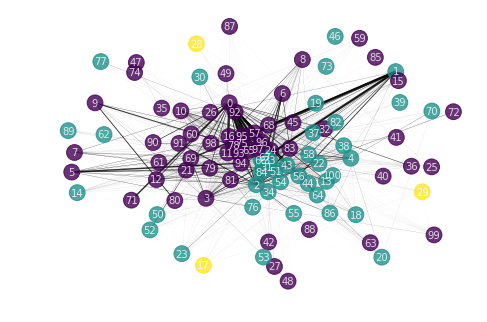

In [17]:
import networkx as nx
names_dict = dict(enumerate(x for x in label_names))
import matplotlib.pyplot as plt
%matplotlib inline
nx.draw(
    clusterer.graph_,
    pos=nx.spring_layout(clusterer.graph_,k=4),
    labels=names_dict,
    with_labels = True,
    width = [10*x/y_train.shape[0] for x in clusterer.weights_['weight']],
    node_color = [membership_vector[i] for i in range(y_train.shape[1])],
    cmap=plt.cm.viridis,
    node_size=250,
    font_size=10,
    font_color='white',
    alpha=0.8
)

In [18]:
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV
import time

parameters = {'k': range(1,3), 's': [0.5, 0.7, 1.0]}
score = 'f1_micro'

start=time.time()

classifier = GridSearchCV(MLkNN(), parameters, scoring=score)
classifier.fit(x_train, y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')
print('best parameters :', classifier.best_params_, 'best score: ',
      clf.best_score_)

/home/eric/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


training time taken:  9720.0 seconds


NameError: name 'clf' is not defined

In [ ]:
print('best parameters :', classifier.best_params_,
      'best score: ',classifier.best_score_)

In [ ]:
from skmultilearn.adapt import BRkNNaClassifier

parameters = {'k': range(3,5)}
score = 'f1_micro'

start=time.time()

classifier = GridSearchCV(BRkNNaClassifier(), parameters, scoring=score)
classifier.fit(x_train, y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')
print('best parameters :', classifier.best_params_,
      'best score: ',classifier.best_score_)


In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier
import time

start=time.time()
classifier = BinaryRelevance(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
)

classifier.fit(x_train, y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')


In [ ]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

In [ ]:
import sklearn.metrics as metrics

br_f1=metrics.f1_score(y_test, y_hat, average='micro')
br_hamm=metrics.hamming_loss(y_test,y_hat)
print('Binary Relevance F1-score:',round(br_f1,3))
print('Binary Relevance Hamming Loss:',round(br_hamm,3))

In [ ]:
from skmultilearn.problem_transform import LabelPowerset

classifier = LabelPowerset(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
)

start=time.time()
classifier.fit(x_train, y_train)
print('training time taken: ',round(time.time()-start,0),'seconds')

In [ ]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

In [ ]:
lp_f1=metrics.f1_score(y_test, y_hat, average='micro')
lp_hamm=metrics.hamming_loss(y_test,y_hat)
print('Label Powerset F1-score:',round(lp_f1,3))
print('Label Powerset Hamming Loss:',round(lp_hamm,3))

In [ ]:
from skmultilearn.problem_transform import ClassifierChain

classifier = ClassifierChain(
    classifier = RandomForestClassifier(),
    require_dense = [False, True],
    order=[i for i in range(nlabel)]
)
start=time.time()
classifier.fit(x_train,y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')

In [ ]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

In [ ]:
cc_f1=metrics.f1_score(y_test, y_hat, average='micro')
cc_hamm=metrics.hamming_loss(y_test,y_hat)
print('Classifier Chain F1-score:',round(cc_f1,3))
print('Classifier Chain Hamming Loss:',round(cc_hamm,3))

In [ ]:
from operator import itemgetter
sorted_deg = [s[0] for s in sorted(nx.betweenness_centrality(clusterer.graph_).items(),
                                   key=itemgetter(1))]
classifier = ClassifierChain(
    classifier = RandomForestClassifier(),
    require_dense = [False, True],
    order=sorted_deg
)
start=time.time()
classifier.fit(x_train,y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')

In [ ]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

In [ ]:
cco_f1=metrics.f1_score(y_test, y_hat, average='micro')
cco_hamm=metrics.hamming_loss(y_test,y_hat)
print('Classifier Chain Ordered F1-score:',round(cco_f1,3))
print('Classifier Chain Ordered Hamming Loss:',round(cco_hamm,3))